In [1]:
import json
import os
import warnings
import csv
import numpy as np
# from utils.zsg_data import FlickrDataset
# from models.slic_vit import SLICViT
# from models.resnet_high_res import ResNetHighRes
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.utils.data import DataLoader
import argparse
from tqdm import tqdm
from datetime import datetime
from collections import OrderedDict
# from utils.pytorchtools import EarlyStopping
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        # Transform
        self.text_liner = nn.Sequential(
            nn.Linear(768, 4096),
            nn.ReLU(inplace=True)
        )
        self.singlemodal_logits = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )
        # weight init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def text_fuse(self, x1, x2):
        x1 = self.text_liner(x1)
        x2 = self.text_liner(x2)
        # Fuse
        x = torch.abs(x1-x2)
        return x
    
    def forward(self, t1, t2):
        t = self.text_fuse(t1, t2)
        logits = self.singlemodal_logits(t)
        return logits

In [13]:
%cd /work/adapting-CLIP-VGPs/
from torch.utils.data import DataLoader
from utils.heatmap_data import VGPsHeatmapsDataset
from models.text_heatmap_final import TextHeatmapFinal

GPU = 7

test_dataset = VGPsHeatmapsDataset(split='test', text_only=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=True
    # sampler=train_sampler
)


/work/adapting-CLIP-VGPs


In [3]:
model = TextClassifier().to(GPU)
model.eval()

TextClassifier(
  (text_liner): Sequential(
    (0): Linear(in_features=768, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (singlemodal_logits): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [4]:
def val(model, heatmap_loader, checkpoint_path, gpu,pos_weight=1,output_type='sigmoid'):
    # print(f'Load model from path: {checkpoint_path}')
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    GPU = gpu
    new_state_dict = OrderedDict()
    for k, v in checkpoint['model_state_dict'].items():
        prefix = 'module.'
        name = k[len(prefix):]  # remove `module.` prefix
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.to(GPU)
    model.eval()

    criterion = nn.BCEWithLogitsLoss()
    if pos_weight != 1:
        pos_weight = torch.tensor([pos_weight]).to(gpu)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    test_results = []
    epoch_loss = 0.0
    epoch_TP = 0
    epoch_FP = 0
    epoch_FN = 0
    epoch_TN = 0
    processed = 0

    with torch.no_grad():
        for batch in heatmap_loader:
            image_paths = batch['img_idx']
            phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
            left_text_ft = batch['left_text_emb']
            right_text_ft = batch['right_text_emb']
            labels = batch['label']
    
            left_text_ft = left_text_ft.squeeze(1).float().to(GPU)
            right_text_ft = right_text_ft.squeeze(1).float().to(GPU)
            label_tensor = labels.float().unsqueeze(1).to(GPU)
            
            outputs = model(left_text_ft, right_text_ft)
            # loss = criterion(outputs, label_tensor)
            if output_type == 'sigmoid':
                loss = criterion(outputs, label_tensor)
                preds = (outputs > 0.5).float()
            elif output_type == 'softmax':
                loss = criterion(outputs, torch.squeeze(label_tensor.type(torch.long)))
                _, preds = outputs.max(dim=1)
                preds = preds.unsqueeze(1)
                
            epoch_loss += loss.item() * len(image_paths)
            epoch_TP += ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
            epoch_FP += ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
            epoch_FN += ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
            epoch_TN += ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()      
        
            processed += len(image_paths)
            
            for i in range(len(image_paths)):
                test_results.append([image_paths[i], phrase_pairs[i], outputs[i].item(), preds[i].item(), labels[i].item()])      
        
        epoch_loss = epoch_loss / processed
        epoch_acc = (epoch_TP + epoch_TN) / processed
        epoch_prec = epoch_TP / (epoch_TP + epoch_FP) if (epoch_TP + epoch_FP) > 0 else 0
        epoch_rec = epoch_TP / (epoch_TP + epoch_FN) if (epoch_TP + epoch_FN) > 0 else 0
        epoch_f1 = 2 * epoch_prec * epoch_rec / (epoch_prec + epoch_rec) if (epoch_prec + epoch_rec) > 0 else 0
    
    
    return test_results, epoch_loss, epoch_acc, epoch_prec, epoch_rec, epoch_f1

In [5]:
import pandas as pd

valid_loss = []
valid_acc = []
valid_prec = []
valid_rec = []
valid_f1 = []

for epoch in tqdm(range(40)):
    checkpoint_path = f'/work/adapting-CLIP-VGPs/checkpoints/text only/10_checkpoint{epoch+1}.pt'
    test_results, epoch_loss, epoch_acc, epoch_prec, epoch_rec, epoch_f1 = val(model, test_loader, checkpoint_path, gpu=4)
    valid_loss.append(epoch_loss)
    valid_acc.append(epoch_acc)
    valid_prec.append(epoch_prec)
    valid_rec.append(epoch_rec)
    valid_f1.append(epoch_f1)

    # data = pd.DataFrame(test_results)
    # csv_path = f'/work/adapting-CLIP-VGPs/checkpoints/text only/10_checkpoint{epoch+1}.csv'
    # data.to_csv(csv_path)

100%|██████████| 40/40 [05:54<00:00,  8.87s/it]


In [7]:
valid_f1.index(max(valid_f1))

36

In [8]:
max(valid_f1)

0.8419755427054697

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def visualize_val(test_results):
    # val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
    pred = [x[3] for x in test_results]
    gt =[ x[4] for x in test_results]

    # Replace actual_labels and predicted_labels with your own data
    cm = confusion_matrix(gt, pred)

    # Define class labels
    class_labels = ['Negative', 'Positive']

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate precision
    precision = precision_score(gt, pred)

    # Calculate recall
    recall = recall_score(gt, pred)

    # Calculate F1 score
    f1 = f1_score(gt, pred)

    # Calculate accuracy
    acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

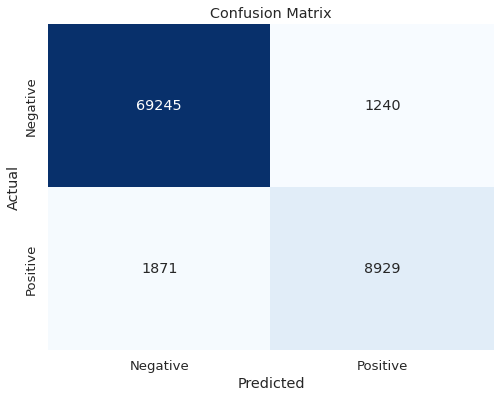

Accuracy: 0.9617272559512825
Precision: 0.8780607729373586
Recall: 0.8267592592592593
F1 Score: 0.851638132481282


In [18]:
visualize_val(test_results)

Text(0, 0.5, 'Recall')

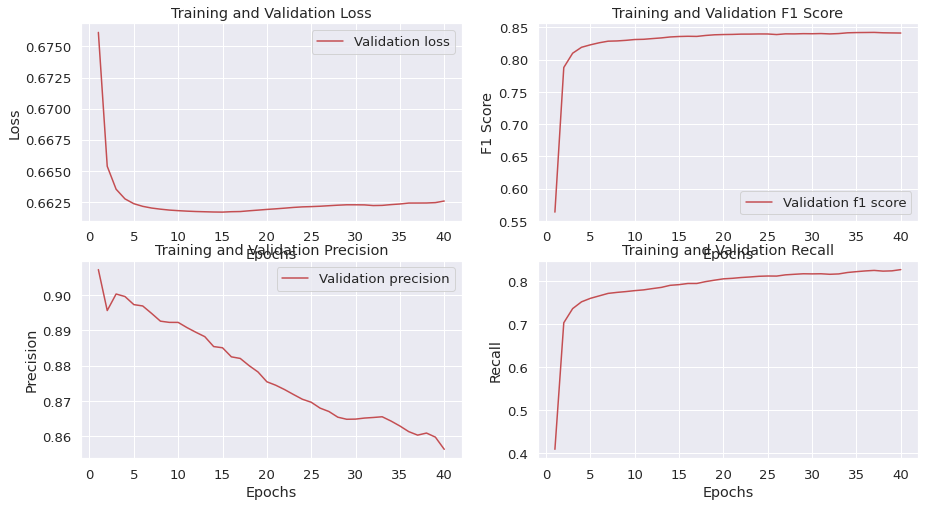

In [17]:
import matplotlib.pyplot as plt
import json


# train_loss = data['train_loss']
# train_acc = data['train_acc']
# train_prec = data['train_prec']
# train_rec = data['train_rec']
# train_f1 = data['train_f1']
# valid_loss = data['valid_loss']
# valid_acc = data['valid_acc']
# valid_prec = data['valid_prec']
# valid_rec = data['valid_rec']
# valid_f1 = data['valid_f1']

epochs = range(1, len(valid_loss) + 1)
epoch_ticks = range(0, len(valid_loss)+1, 4)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

# Plot training and validation loss
# ax1.plot(epochs, train_loss, 'b', label='Training loss')
ax1.plot(epochs, valid_loss, 'r', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
# ax1.set_xticks(epoch_ticks)

# Plot training and validation f1
# ax2.plot(epochs, train_f1, 'b', label='Training f1 score')
ax2.plot(epochs, valid_f1, 'r', label='Validation f1 score')
ax2.set_title('Training and Validation F1 Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()
# ax2.set_xticks(epoch_ticks)

# Plot training and validation precision
# ax3.plot(epochs, train_prec, 'b', label='Training precision')
ax3.plot(epochs, valid_prec, 'r', label='Validation precision')
ax3.set_title('Training and Validation Precision')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precision')
ax3.legend()
# ax3.set_xticks(epoch_ticks)

# Plot training and validation recall
# ax4.plot(epochs, train_rec, 'b', label='Training recall')
ax4.plot(epochs, valid_rec, 'r', label='Validation recall')
ax4.set_title('Training and Validation Recall')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Recall')


In [16]:
valid_loss

[0.676132520993053,
 0.6653602472179228,
 0.6635155050918846,
 0.662738230233056,
 0.6623503016547543,
 0.6621388496262837,
 0.6620013332125908,
 0.6619108732553597,
 0.6618379302087859,
 0.6617909821327199,
 0.6617517740236168,
 0.6617219002859949,
 0.6617022013488115,
 0.6616828810312656,
 0.6616742131847623,
 0.6617068143764381,
 0.6617200636880525,
 0.6617803469036776,
 0.6618345640535652,
 0.6618898443150921,
 0.6619381686283528,
 0.661992131405445,
 0.6620511115353322,
 0.6620950741417275,
 0.6621167207574655,
 0.6621463729984067,
 0.662189439691224,
 0.6622304482134491,
 0.662262339556459,
 0.6622616566148134,
 0.6622546219450178,
 0.6622011689136509,
 0.6622145531608641,
 0.6622775047407169,
 0.6623274639071649,
 0.6624025389447566,
 0.6624042738018416,
 0.6624076161714066,
 0.6624383022198883,
 0.6625659228294645]